# PolyShape-2D Dataset generator

This notebook implements the generation of the synthetic dataset as described in the accompanying report.

In [1]:
# SETUP AND IMPORTS
import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

# CONFIGURATION PARAMETERS
# All parameters are defined here for easy modification.

IMG_SIZE = 64  # Final image resolution (width and height)
SUPERSAMPLE_FACTOR = 4 # Factor for anti-aliasing (e.g., 4x supersampling)
CANVAS_SIZE = IMG_SIZE * SUPERSAMPLE_FACTOR
SHAPE_SCALE = 0.75 # Scale of the shape relative to the canvas size
BG_COLOR = 0     # Black background
FG_COLOR = 255   # White shape

# Stochasticity Parameters
JITTER_STRENGTH = 0.5 # Max sub-pixel jitter in pixels for the supersampled canvas
NOISE_STD_DEV = 0.01  # Standard deviation for Gaussian noise (applied to float image 0-1)

# Dataset structure parameters
ROOT_DIR = 'PolyShape-2D' # Root directory for the dataset

# Number of images to generate for each dataset split.
# Modify these values to control the size of your generated dataset.
NUM_SAMPLES = {
    'train_h1': 10,      # Per class, upright only (for H1)
    'train_h2_100': 5,   # Per class, fully rotated (for H2)
    'train_h2_500': 10,  # Per class, fully rotated (for H2)
    'train_h2_3000': 15, # Per class, fully rotated (for H2)
    'validation': 15,    # Per class, fully rotated
    'test': 30           # Per class, fully rotated
}

print("Configuration parameters set.")

Libraries imported successfully.
Configuration parameters set.


## Shape vertex generation and core image generation functions

In [2]:
# SHAPE VERTEX GENERATION FUNCTIONS

def generate_regular_polygon_vertices(n_sides):
    """Generates vertices for a regular polygon centered at the origin."""
    # The radius is set to 1, as it will be scaled later
    radius = 1
    # Calculate angles for each vertex
    angles = np.linspace(0, 2 * np.pi, n_sides, endpoint=False) - np.pi / 2
    # Calculate vertex coordinates (x, y)
    vertices = [(radius * np.cos(a), radius * np.sin(a)) for a in angles]
    return np.array(vertices)

def generate_star_vertices(n_points, inner_ratio):
    """Generates vertices for a star centered at the origin."""
    radius = 1
    outer_angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False) - np.pi / 2
    inner_angles = outer_angles + np.pi / n_points
    
    vertices = []
    for i in range(n_points):
        # Outer point
        vertices.append((radius * np.cos(outer_angles[i]), radius * np.sin(outer_angles[i])))
        # Inner point
        vertices.append((radius * inner_ratio * np.cos(inner_angles[i]), radius * inner_ratio * np.sin(inner_angles[i])))
        
    return np.array(vertices)


# CORE IMAGE GENERATION FUNCTION

def generate_image(shape_vertices, rotation_angle_deg, jitter=True, noise=True):
    """
    Generates a single image of a shape with specified rotation and stochasticity.
    
    Args:
        shape_vertices (np.array): Nx2 array of vertex coordinates.
        rotation_angle_deg (float): Rotation angle in degrees.
        jitter (bool): If True, applies sub-pixel translational jitter.
        noise (bool): If True, applies Gaussian noise.

    Returns:
        PIL.Image: The final generated grayscale image.
    """
    # Create a high-resolution canvas for supersampling
    image = Image.new('L', (CANVAS_SIZE, CANVAS_SIZE), BG_COLOR)
    draw = ImageDraw.Draw(image)

    # Define rotation matrix
    angle_rad = np.deg2rad(rotation_angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])

    # Apply rotation to vertices
    rotated_vertices = np.dot(shape_vertices, rotation_matrix.T)
    
    # Scale and center the shape
    scaled_radius = (CANVAS_SIZE / 2) * SHAPE_SCALE
    centered_vertices = rotated_vertices * scaled_radius + (CANVAS_SIZE / 2)
    
    # Apply sub-pixel jitter
    if jitter:
        jitter_offset = np.random.uniform(-JITTER_STRENGTH, JITTER_STRENGTH, 2)
        centered_vertices += jitter_offset

    # Draw the polygon onto the high-resolution canvas
    draw.polygon([tuple(p) for p in centered_vertices], fill=FG_COLOR)

    # Downsample to final resolution with anti-aliasing
    final_image = image.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    
    # Add Gaussian noise (non-rotational stochasticity)
    if noise:
        # Convert to float array between 0 and 1
        img_array = np.array(final_image) / 255.0
        # Add noise and clip to valid range
        noise_array = np.random.normal(0, NOISE_STD_DEV, img_array.shape)
        img_array = np.clip(img_array + noise_array, 0.0, 1.0)
        # Convert back to uint8 image
        final_image = Image.fromarray((img_array * 255).astype(np.uint8))

    return final_image

print("Core image generation function defined.")

Core image generation function defined.


## Dataset generation script

In [3]:
# Class definitions
# Mapping class names to a function that generates their vertices
CLASS_DEFINITIONS = {
    '0_triangle': lambda: generate_regular_polygon_vertices(3),
    '1_square': lambda: generate_regular_polygon_vertices(4),
    '2_pentagon': lambda: generate_regular_polygon_vertices(5),
    '3_hexagon': lambda: generate_regular_polygon_vertices(6),
    '4_heptagon': lambda: generate_regular_polygon_vertices(7),
    '5_octagon': lambda: generate_regular_polygon_vertices(8),
    '6_star': lambda: generate_star_vertices(5, 0.5), # 5-pointed star
    '7_circle': lambda: generate_regular_polygon_vertices(60) # Circle approximated by 60-gon
}


# DATASET GENERATION SCRIPT

def create_dataset_structure(split_name, class_name):
    """Creates the necessary directories for saving images."""
    path = os.path.join(ROOT_DIR, split_name, class_name)
    os.makedirs(path, exist_ok=True)
    return path

def generate_dataset(split_name, num_per_class):
    """
    Generates and saves a full dataset split.

    Args:
        split_name (str): The name of the split (e.g., 'train_h1', 'test').
        num_per_class (int): Number of images to generate for each class.
    """
    print(f"\nGenerating dataset split: '{split_name}'")
    print(f"Number of images per class: {num_per_class}")
    
    is_upright_only = (split_name == 'train_h1')
    
    if is_upright_only:
        print("Orientation: Upright only (0 degrees)")
    else:
        print("Orientation: Random (0-360 degrees)")
        
    for class_name, vertex_func in tqdm(CLASS_DEFINITIONS.items(), desc="Processing classes"):
        # Create directory for the class
        save_path = create_dataset_structure(split_name, class_name)
        
        # Generate vertices for the base shape
        base_vertices = vertex_func()
        
        for i in range(num_per_class):
            # Determine rotation angle based on the split type
            rotation_angle = 0.0 if is_upright_only else np.random.uniform(0, 360)
            
            # Generate the image
            img = generate_image(base_vertices, rotation_angle)
            
            # Save the image
            img_filename = f"{i:05d}.png"
            img.save(os.path.join(save_path, img_filename))
            
    print(f"Finished generating '{split_name}'")

## Execution and visualization


Generating dataset split: 'train_h1'
Number of images per class: 10
Orientation: Upright only (0 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 39.28it/s]


Finished generating 'train_h1'

Generating dataset split: 'train_h2_100'
Number of images per class: 5
Orientation: Random (0-360 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 181.63it/s]


Finished generating 'train_h2_100'

Generating dataset split: 'train_h2_500'
Number of images per class: 10
Orientation: Random (0-360 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 82.60it/s]


Finished generating 'train_h2_500'

Generating dataset split: 'train_h2_3000'
Number of images per class: 15
Orientation: Random (0-360 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 68.45it/s]


Finished generating 'train_h2_3000'

Generating dataset split: 'validation'
Number of images per class: 15
Orientation: Random (0-360 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 67.76it/s]


Finished generating 'validation'

Generating dataset split: 'test'
Number of images per class: 30
Orientation: Random (0-360 degrees)


Processing classes: 100%|██████████| 8/8 [00:00<00:00, 34.33it/s]


Finished generating 'test'


All dataset splits generated successfully!

Visualizing samples from 'train_h1'


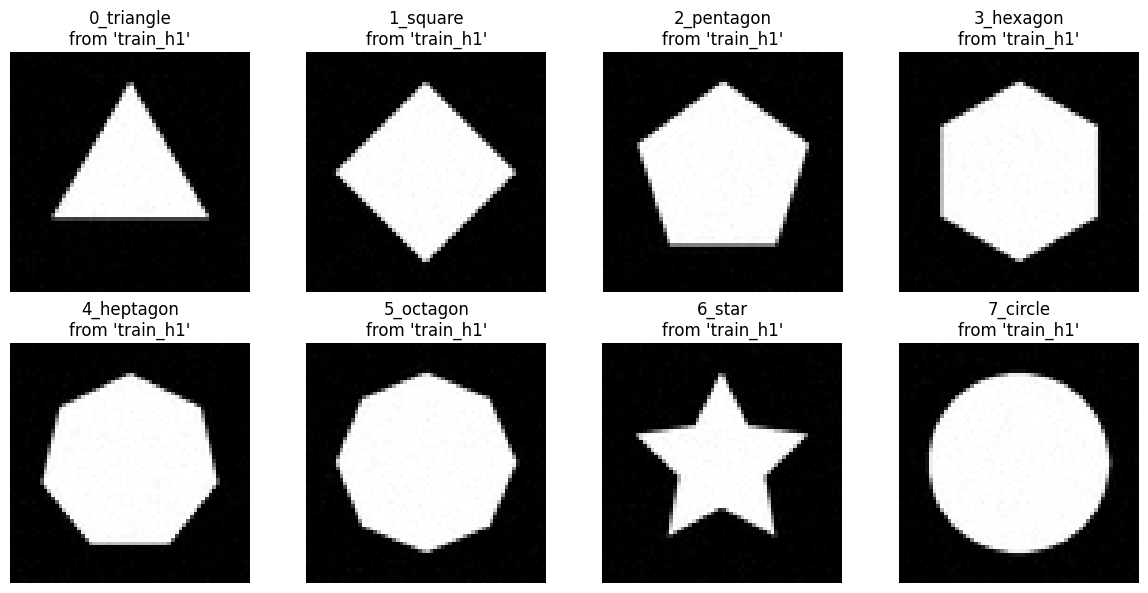


Visualizing samples from 'test'


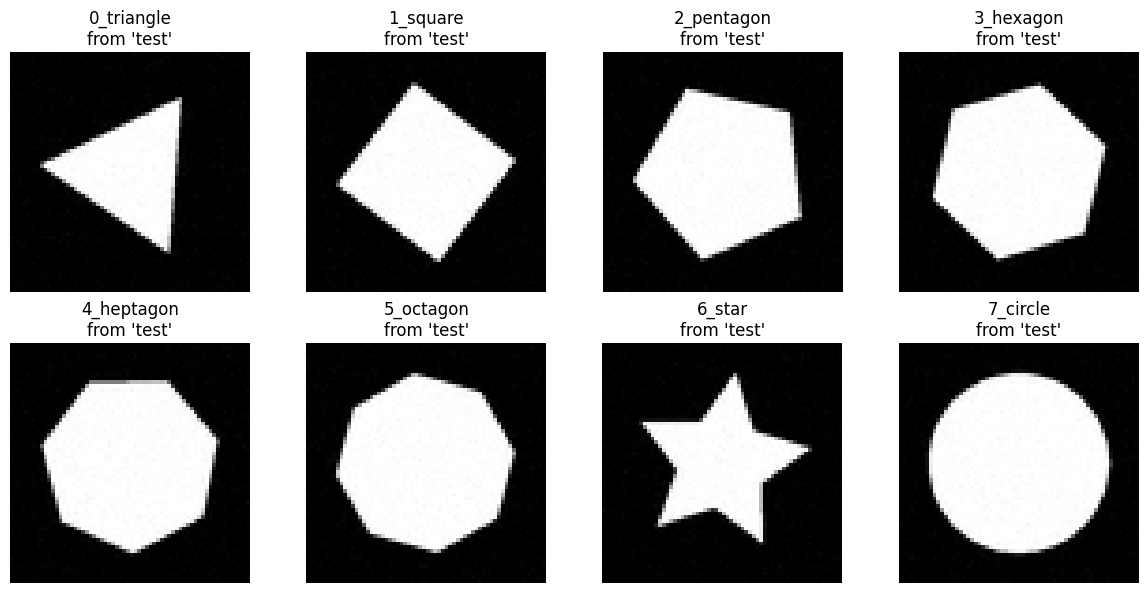

In [4]:
# VERIFICATION AND VISUALIZATION

def visualize_samples(split_name):
    """Loads and displays a few random samples from a generated split."""
    print(f"\nVisualizing samples from '{split_name}'")
    
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(CLASS_DEFINITIONS.keys()):
        plt.subplot(2, 4, i + 1)
        
        class_path = os.path.join(ROOT_DIR, split_name, class_name)
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue
            
        sample_file = np.random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, sample_file)
        
        img = Image.open(img_path)
        
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name}\nfrom '{split_name}'")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Generate all the defined dataset splits
    for split, num_samples in NUM_SAMPLES.items():
        generate_dataset(split, num_samples)
        
    print("\n\nAll dataset splits generated successfully!")

    # Visualize samples from the strict H1 training set and the test set
    visualize_samples('train_h1')
    visualize_samples('test')
